Notebook purpose

- Develop analysis code

In [1]:
import contextlib
import math
import os
import re
import sys

import linearmodels as lm
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tabulate

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.analysis.helpers as ah
import entropy.analysis.sumstats_table as ss
import entropy.data.aggregators as ag
import entropy.data.cleaners as cl
import entropy.data.selectors as sl
import entropy.figures.figures as ff
import entropy.figures.helpers as fh
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh
from entropy import config

sns.set_style("whitegrid")
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile="3di")

SAMPLE = "XX7"

In [2]:
import warnings

warnings.filterwarnings("once")

## Data description

In [3]:
df = hd.read_analysis_data('')
hd.inspect(df)

Time for read_analysis_data            : 2.26 seconds
(85,364, 26)


,user_id,month,date,active_accounts,age,annual_income,entropy,entropyz,female,has_sa_inflows,month_income,month_spend,sa_inflows,spend_communication,spend_finance,spend_hobbies,spend_household,spend_motor,spend_other_spend,spend_retail,spend_services,spend_travel,txn_count_ca,txn_count_sa,txns_count,txns_value
124,37,2,2012-02-29,"[287407, 287405, 287406, 287404]",27.0,18768.632812,2.899397,1.137196,0.0,1,1687.530029,528.239990,3340.0,50.0,0.0,0.0,312.640015,0.0,46.799999,0.0,118.800003,0.0,8.0,3.0,22,9495.810547
125,37,3,2012-03-31,"[287405, 287407, 287406, 287404]",27.0,18768.632812,3.039149,1.661248,0.0,0,1085.790039,429.880005,0.0,50.0,0.0,0.0,327.500000,0.0,40.000000,0.0,12.380000,0.0,9.0,2.0,16,2147.699951


/Users/fgu/miniconda3/envs/entropy/lib/python3.9/asyncio/sslproto.py:320: ResourceWarning: unclosed transport <asyncio.sslproto._SSLProtocolTransport object at 0x167de4520>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)


**Sample selection - see paper**

**Number of unique users**

In [116]:
df.user_id.nunique()

2819

**Number of months we observe users for**

count    2819.000000
mean       30.281660
std        17.510864
min         6.000000
25%        16.000000
50%        26.000000
75%        41.000000
max       102.000000
dtype: float64


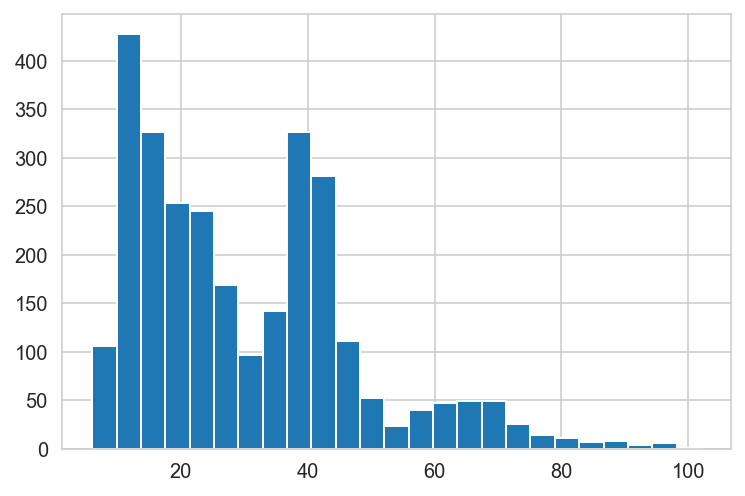

In [117]:
user_months = df.groupby("user_id").size()
print(user_months.describe())
user_months.hist(bins=25);

**User characteristics**

/Users/fgu/miniconda3/envs/entropy/lib/python3.9/asyncio/sslproto.py:320: ResourceWarning: unclosed transport <asyncio.sslproto._SSLProtocolTransport object at 0x164bf46a0>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)


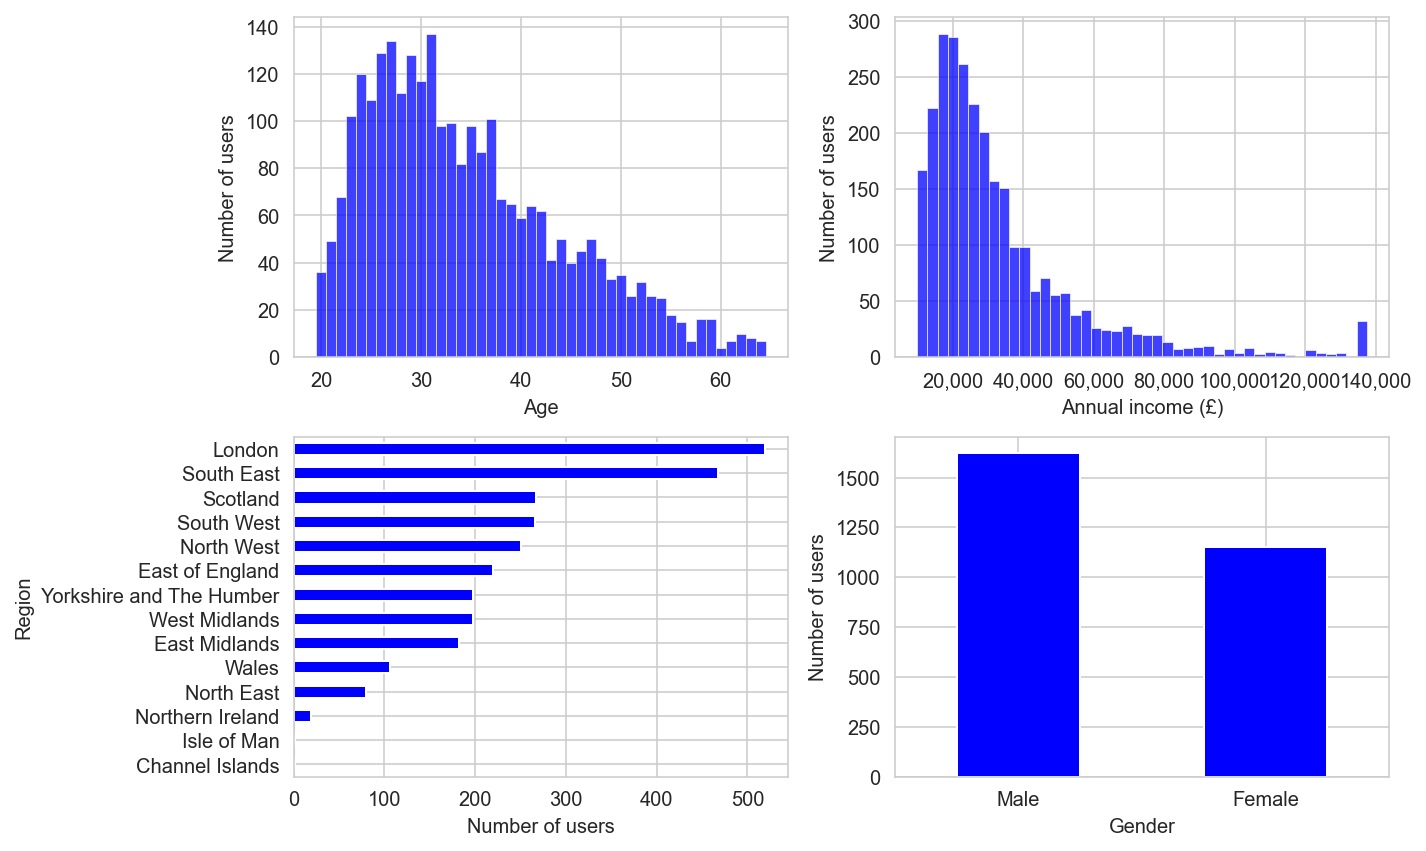

In [9]:
ff.user_chars(df, write=False)

**Summary statistics**

In [132]:
ss.main(df, write=False)

,count,mean,std,min,max,25%,50%,75%
user_id,729.0,354516.368999,147382.596599,13777.000000,5.537770e+05,316777.000000,393777.000000,430777.000000
month,729.0,6.427984,3.450687,1.000000,1.200000e+01,3.000000,6.000000,9.000000
age,729.0,38.458162,12.944459,19.000000,7.100000e+01,28.000000,37.000000,44.000000
annual_income,729.0,27682.949957,17111.518305,10535.050781,9.688784e+04,18128.519531,22883.554688,30535.039062
entropy,729.0,2.577758,0.243376,1.395843,3.095795e+00,2.441449,2.599220,2.738609
entropyz,729.0,-0.087953,0.907710,-4.496099,1.844151e+00,-0.596338,-0.007907,0.511965
female,729.0,0.441701,0.496931,0.000000,1.000000e+00,0.000000,0.000000,1.000000
has_sa_inflows,729.0,0.536351,0.499019,0.000000,1.000000e+00,0.000000,1.000000,1.000000
month_income,729.0,2261.288330,1426.108032,-0.000000,9.285477e+03,1453.540039,1918.660034,2771.600098
sa_inflows,729.0,1322.963989,15559.435547,0.000000,4.152500e+05,0.000000,55.599998,649.539978


/Users/fgu/miniconda3/envs/entropy/lib/python3.9/asyncio/sslproto.py:320: ResourceWarning: unclosed transport <asyncio.sslproto._SSLProtocolTransport object at 0x16999f460>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)


## Independent variable - entropy

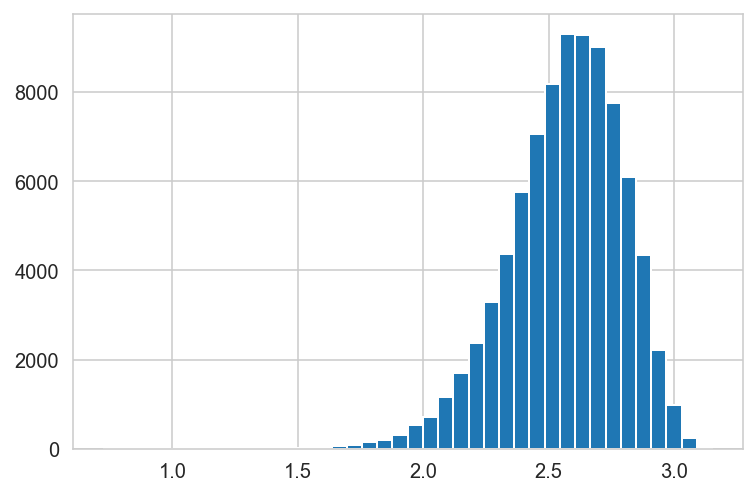

In [119]:
df.entropy_sptac.hist(bins=40);

## Main results

In [124]:
df = df.set_index(["user_id", "date"])

In [125]:
data = df

y = data["has_sa_inflows"]

var_of_interest = ["entropy_sptac_std"]
tag_spends = list(data.filter(regex="^spend_(?!month)").columns)
controls = ["month_income"]
exog = data[var_of_interest + controls + tag_spends]

results = lm.panel.compare(
    [
        ah.fe_reg(
            y,
            data[var_of_interest],
            entity_effects=True,
            time_effects=True,
        ),
        ah.fe_reg(
            y,
            data[var_of_interest + ["spend_month"]],
            entity_effects=True,
            time_effects=True,
        ),
        ah.fe_reg(
            y,
            data[var_of_interest + ["spend_month", "month_income"]],
            entity_effects=True,
            time_effects=True,
        ),
        ah.fe_reg(
            y,
            data[var_of_interest + tag_spends],
            entity_effects=True,
            time_effects=True,
        ),
        ah.fe_reg(y, exog, entity_effects=True, time_effects=True),
    ],
    stars=True,
)
print(results)

                                                   Model Comparison                                                   
                                   Model 0            Model 1            Model 2            Model 3            Model 4
----------------------------------------------------------------------------------------------------------------------
Dep. Variable               has_sa_inflows     has_sa_inflows     has_sa_inflows     has_sa_inflows     has_sa_inflows
Estimator                         PanelOLS           PanelOLS           PanelOLS           PanelOLS           PanelOLS
No. Observations                     85364              85364              85364              85364              85364
Cov. Est.                        Clustered          Clustered          Clustered          Clustered          Clustered
R-squared                           0.0009             0.0035             0.0070             0.0049             0.0079
R-Squared (Within)                  0.0014      

/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/linearmodels/panel/results.py:1010: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  vals = concat(


### Fixed effects

Comparese effect of including individual and month fixed effects.

In [126]:
data = df

y = data["has_sa_inflows"]

var_of_interest = ["entropy_sptac_std"]
tag_spends = list(data.filter(regex="^spend_(?!month)").columns)
controls = ["month_income"]
exog = data[var_of_interest + controls + tag_spends]

results = lm.panel.compare(
    [
        ah.fe_reg(y, exog, entity_effects=True, time_effects=True),
        ah.fe_reg(y, exog, entity_effects=True, time_effects=False),
        ah.fe_reg(y, exog, entity_effects=False, time_effects=True),
        ah.fe_reg(y, exog, entity_effects=False, time_effects=False),
    ],
    stars=True,
)
print(results)

                                          Model Comparison                                         
                                   Model 0            Model 1            Model 2            Model 3
---------------------------------------------------------------------------------------------------
Dep. Variable               has_sa_inflows     has_sa_inflows     has_sa_inflows     has_sa_inflows
Estimator                         PanelOLS           PanelOLS           PanelOLS           PanelOLS
No. Observations                     85364              85364              85364              85364
Cov. Est.                        Clustered          Clustered          Clustered          Clustered
R-squared                           0.0079             0.0137             0.0023             0.4006
R-Squared (Within)                  0.0128             0.0137             0.0022            -0.0466
R-Squared (Between)                 0.2278             0.2800             0.0546             0.5696


/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/linearmodels/panel/results.py:1010: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  vals = concat(


### Clustering specification

Clustering by entity effects reduces t-stats significantly, indicating that there is important correlation among residuals within an individual. Clustering also by time effects doesn't change t-stats much, indicating that there is not a lot of cross-sectional dependence across months of the year in the data. As a result, we just clusert by entity effects in the main results above.

In [128]:
data = df

y = data["has_sa_inflows"]

var_of_interest = ["entropy_sptac_std"]
tag_spends = list(data.filter(regex="^spend_(?!month)").columns)
controls = ["month_income"]
exog = data[var_of_interest + controls + tag_spends]

results = lm.panel.compare(
    [
        lm.PanelOLS(y, exog, entity_effects=True, time_effects=True).fit(),
        lm.PanelOLS(y, exog, entity_effects=True, time_effects=True).fit(
            cov_type="clustered", cluster_entity=True, cluster_time=False
        ),
        lm.PanelOLS(y, exog, entity_effects=True, time_effects=True).fit(
            cov_type="clustered", cluster_entity=True, cluster_time=True
        ),
    ],
    stars=True,
)
print(results)

/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/linearmodels/panel/results.py:1010: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  vals = concat(


                                Model Comparison                                
                                   Model 0            Model 1            Model 2
--------------------------------------------------------------------------------
Dep. Variable               has_sa_inflows     has_sa_inflows     has_sa_inflows
Estimator                         PanelOLS           PanelOLS           PanelOLS
No. Observations                     85364              85364              85364
Cov. Est.                       Unadjusted          Clustered          Clustered
R-squared                           0.0079             0.0079             0.0079
R-Squared (Within)                  0.0128             0.0128             0.0128
R-Squared (Between)                 0.2278             0.2278             0.2278
R-Squared (Overall)                 0.1793             0.1793             0.1793
F-statistic                         59.904             59.904             59.904
P-value (F-stat)            

## Effect sizes

Approach:

- Predict baseline probablity of making savings account transfer using means of all dependent variables, with entropy mean set to zero. (How to handle fixed effects? lm seems to provide estimates for them, but not clear where they come from. Use for now.)

- Predict probability if entropy mean is one.

- Calculate percentage change.

# m = ah.fe_reg(y, exog, entity_effects=True, time_effects=True)

Fitted values seem to be calculated ignoring estimated fixed effects.

In [241]:
fitted_manual = (exog * m.params).sum(1).rename("fitted_values")
pd.testing.assert_series_equal(fitted_manual, m.fitted_values.fitted_values)

Also, they seem too high, given how rare savings account inflows actually are in the data.

In [242]:
fitted_manual.describe()

count    84096.000000
mean         0.864129
std          0.254827
min          0.383120
25%          0.667794
50%          0.818483
75%          1.022256
max          1.877679
Name: fitted_values, dtype: float64

In [243]:
y.describe()

count    84096.000000
mean         0.520417
std          0.499586
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: has_sa_inflows, dtype: float64

Adding estimated effects, we get the exact mean of the data, and also much fewer predictions above 1.

In [244]:
(m.fitted_values.fitted_values + m.estimated_effects.estimated_effects).describe(
    percentiles=[0.05, 0.25, 0.5, 0.75, 0.9, 0.95]
)

count    84096.000000
mean         0.520417
std          0.336518
min         -0.335529
5%           0.020124
25%          0.222271
50%          0.504137
75%          0.841471
90%          0.985436
95%          1.010316
max          1.345141
dtype: float64

Probability at entropy = 0

In [274]:
exog_bl = exog.copy()
exog_bl["entropy_sptac_std"] = 0
prob_bl = (
    exog_bl.mean() * m.params
).sum() + r.estimated_effects.estimated_effects.mean()
prob_bl

0.5204171442396448

Probability at entropy = 1

In [256]:
exog_inc = exog_bl.copy()
exog_inc["entropy_sptac_std"] = 1
prob_inc = (
    exog_inc.mean() * m.params
).sum() + r.estimated_effects.estimated_effects.mean()
prob_inc

0.5103373852693549

Percentage change for 1 std increase

In [258]:
dprob = ((prob_inc - prob_bl) / prob_bl) * 100
dprob

-1.9368614354580735

Moving from 25th to 75th percentile

In [273]:
stats = df.entropy_sptac.describe()
stds = (stats.loc["75%"] - stats.loc["25%"]) / stats.loc["std"]
stds * dprob

-2.545343299010333